# Spam or Ham
Hello! In this notebook we will be implementing an algorithm to classify an email to be spam or ham. We will preprocess the data by using Natural Language Processing (NLP), then build three different machine learning models (Naive Bayes, Support Vector Machines, and K-Nearest Neighbor) to evaluate the data and compare them with each other.

# Load data
Import and download the necessary resources

In [25]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline    
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.metrics import precision_score, recall_score, ConfusionMatrixDisplay, classification_report, accuracy_score, f1_score
from sklearn import metrics

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\justi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv("spam1.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sms     5574 non-null   object
 1   label   5574 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


,sms,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...\n,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


The dataset consists of 5,574 messages in English. The data is designated as ham(0) or spam(1).

# Data Exploration

Text(0, 0.5, 'Number of Data points')

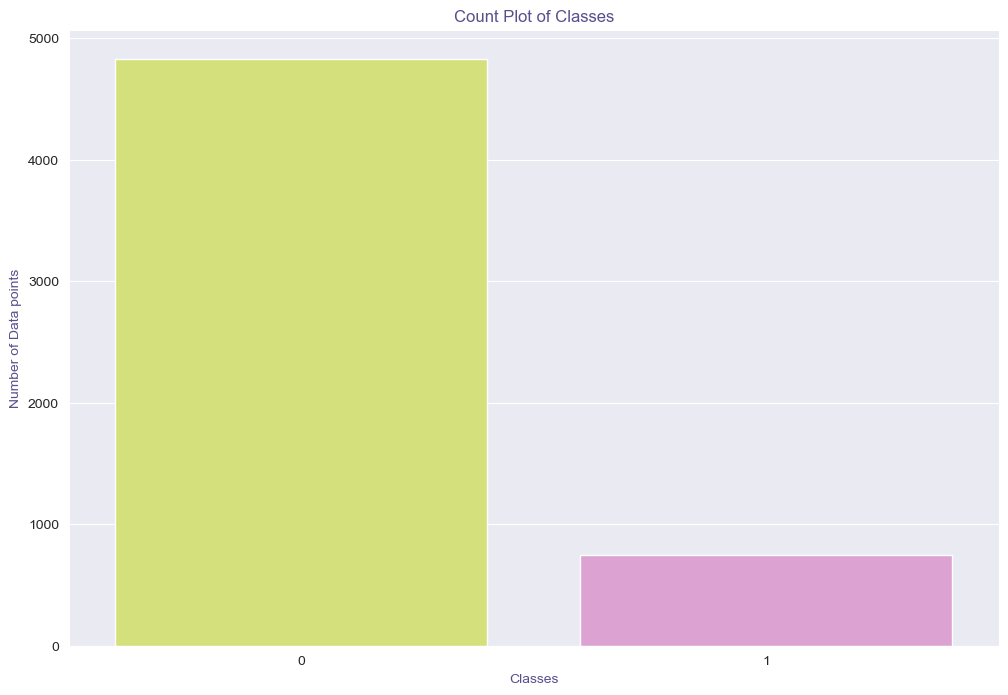

In [3]:
# Palette
cols= ["#E1F16B", "#E598D8"] 
# Show a plot of the data
plt.figure(figsize=(12,8))
fg = sns.countplot(data=df, x="label", hue="label", palette= cols, legend=False)
fg.set_title("Count Plot of Classes", color="#58508d")
fg.set_xlabel("Classes", color="#58508d")
fg.set_ylabel("Number of Data points", color="#58508d")

Create new features: No_of_Characters, No_of_Words, and No_of_Sentences

In [4]:
df["no_of_characters"] = df["sms"].apply(len)
df["no_of_words"]=df.apply(lambda row: nltk.word_tokenize(row["sms"]), axis=1).apply(len)
df["no_of_sentences"]=df.apply(lambda row: nltk.sent_tokenize(row["sms"]), axis=1).apply(len)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
label,5574.0,0.134015,0.340699,0.0,0.0,0.0,0.0,1.0
no_of_characters,5574.0,81.478292,59.848302,3.0,37.0,63.0,123.0,911.0
no_of_words,5574.0,18.854324,13.838509,1.0,9.0,15.0,27.0,220.0
no_of_sentences,5574.0,2.005920,1.539876,1.0,1.0,2.0,3.0,38.0


C:\Users\justi\miniconda3\envs\env_cs450\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

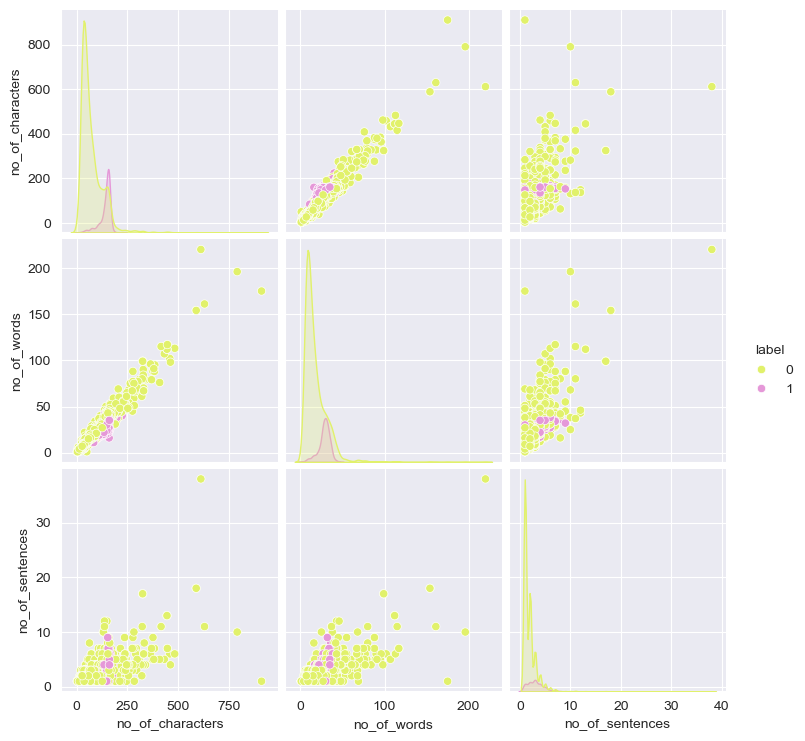

In [5]:
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label", palette= cols)
plt.show(fg)

Note: As we can see, there are a few outliers so the next step should be dropping the outliers.

C:\Users\justi\miniconda3\envs\env_cs450\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1200x800 with 0 Axes>

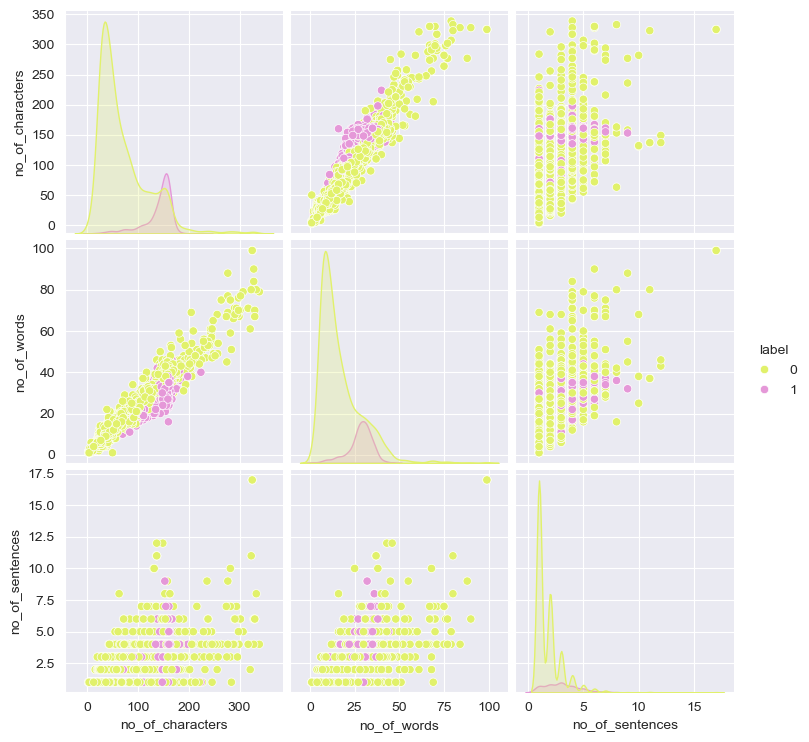

In [6]:
df = df[(df["no_of_characters"]<350)]
plt.figure(figsize=(12,8))
fg = sns.pairplot(data=df, hue="label",palette=cols)
plt.show(fg)

# Data Preprocessing
### A. Clean the text
#### 1. Extract only alphabetic characters
#### 2. Convert all characters to lowercase

In [7]:
def clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) # Replacing all non-alphabetic characters with a space
    sms = sms.lower() # Converting to lowercase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df["clean_sms"] = df["sms"].apply(clean)


#### First 5 texts after cleaning:

In [8]:
# Output a sample of texts after cleaning
print(*df["clean_sms"][:5], sep = "\n")

go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat
ok lar joking wif u oni
free entry in a wkly comp to win fa cup final tkts st may text fa to to receive entry question std txt rate t c s apply over s
u dun say so early hor u c already then say
nah i don t think he goes to usf he lives around here though


### B. Tokenization
#### Tokenization is important to perform feature extraction (TF-IDF) and to handle garbage data.

In [9]:
df["tokenize_sms"]=df.apply(lambda row: nltk.word_tokenize(row["clean_sms"]), axis=1)
print(*df["tokenize_sms"][:5], sep = "\n")

['go', 'until', 'jurong', 'point', 'crazy', 'available', 'only', 'in', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'there', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'in', 'a', 'wkly', 'comp', 'to', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'to', 'to', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 't', 'c', 's', 'apply', 'over', 's']
['u', 'dun', 'say', 'so', 'early', 'hor', 'u', 'c', 'already', 'then', 'say']
['nah', 'i', 'don', 't', 'think', 'he', 'goes', 'to', 'usf', 'he', 'lives', 'around', 'here', 'though']


### C. Removing Stopwords
#### Stopwords are frequently occurring words like few, is, an, etc. These words do not contribute much in NLP so we will be removing stopwords.

In [10]:
# Function to remove stopwords
def remove_stopwords(Text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in Text if word not in stop_words]
    return filtered_text

df["nostopword_sms"] = df["tokenize_sms"].apply(remove_stopwords)

# Output the first 5 texts after removing the stopwords
print(*df["nostopword_sms"][:5], sep = "\n")

['go', 'jurong', 'point', 'crazy', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet', 'cine', 'got', 'amore', 'wat']
['ok', 'lar', 'joking', 'wif', 'u', 'oni']
['free', 'entry', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', 'st', 'may', 'text', 'fa', 'receive', 'entry', 'question', 'std', 'txt', 'rate', 'c', 'apply']
['u', 'dun', 'say', 'early', 'hor', 'u', 'c', 'already', 'say']
['nah', 'think', 'goes', 'usf', 'lives', 'around', 'though']


# Feature Extraction by using Term Frequency-Inverse Document Frequency (TF-IDF)
TF-IDF allows the cleaned data to be converted into a numerical format where each word is represented by a matrix. This is known as word vectorization.

#### Steps in word vectorization:
#### 1. Create a corpus of nostopword_sms
#### 2. Convert corpus to vector form
#### 3. Label encode the label and use it as y

In [11]:
corpus = []
for i in df["nostopword_sms"]:
    msg = ' '.join([row for row in i])
    corpus.append(msg)
    
corpus[:5]

# Output first 5 lines of corpus
print(*corpus[:5], sep = "\n")

go jurong point crazy available bugis n great world la e buffet cine got amore wat
ok lar joking wif u oni
free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply
u dun say early hor u c already say
nah think goes usf lives around though


In [12]:
# Change text data into numbers
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus).toarray()

# Label encode the label and use it as y
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

# Model Building
#### Steps in model building:
#### 1. Set up features and target as x and y
#### 2. Split the testing and training sets
#### 3. Build model of three different classifiers
#### 4. Fit all the models on training data
#### 5. Get the cross-validation on the training set for all the model for accuracy

In [13]:
# Setting values for labels and feature as y and x(we already did x in vectorizing...)
y = df["label"] 
# Splitting the testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Testing on the following models
classifiers = [MultinomialNB(), 
               KNeighborsClassifier(), 
               SVC()]

for cls in classifiers:
    cls.fit(X_train, y_train)

# Dictionary of model types
models_dict = {0: "NaiveBayes", 1: "KNN", 2: "SVC"}

In [17]:
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=2)
    print("%s: %f " % (models_dict[i], cv_score.mean()))

NaiveBayes: 0.941216 
KNN: 0.896622 
SVC: 0.960586 


# Evaluate the models

In [19]:
# Create lists of various metrics
precision =[]
recall =[]
f1_score = []
trainset_accuracy = []
testset_accuracy = []

for i in classifiers:
    pred_train = i.predict(X_train)
    pred_test = i.predict(X_test)
    prec = metrics.precision_score(y_test, pred_test)
    recal = metrics.recall_score(y_test, pred_test)
    f1_s = metrics.f1_score(y_test, pred_test)
    train_accuracy = model.score(X_train,y_train)
    test_accuracy = model.score(X_test,y_test)
  
    #Appending scores
    precision.append(prec)
    recall.append(recal)
    f1_score.append(f1_s)
    trainset_accuracy.append(train_accuracy)
    testset_accuracy.append(test_accuracy)

In [20]:
# Initialize data of lists.
data = {'Precision':precision,
'Recall':recall,
'F1score':f1_score,
'Accuracy on Test set':testset_accuracy,
'Accuracy on Train set':trainset_accuracy}

# Creates pandas DataFrame.
results = pd.DataFrame(data, index =["NaiveBayes", "KNN", "SVC"])

In [22]:
cmap2 = ListedColormap(["#E2CCFF","#E598D8"])
results.style.background_gradient(cmap=cmap2)

,Precision,Recall,F1score,Accuracy on Test set,Accuracy on Train set
NaiveBayes,1.000000,0.771429,0.870968,0.972973,0.997973
KNN,1.000000,0.377143,0.547718,0.972973,0.997973
SVC,0.993197,0.834286,0.906832,0.972973,0.997973


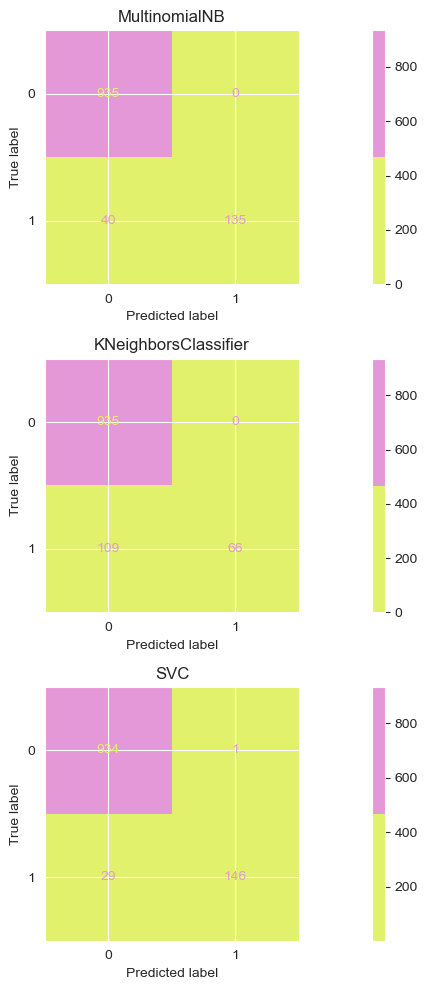

In [31]:
cmap = ListedColormap(["#E1F16B", "#E598D8"])
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(15,10))

for cls, ax in zip(classifiers, axes.flatten()):
    ConfusionMatrixDisplay.from_predictions(
        y_test,
        cls.predict(X_test),
        ax=ax,
        cmap=cmap,
    )
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

